In [ ]:
# For Google Colab Use
COLAB = True
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    %cd '/content/drive/MyDrive/Coding/Projects/MarketMakingAgents/market-making-agents'
    #!git reset --hard origin/master
    #!git pull
    #!git checkout .

In [ ]:
if COLAB:
    %load_ext tensorboard
    %tensorboard --logdir runs

    # Clear any logs from previous runs
    !rm -rf ./runs/

    %reload_ext tensorboard
    # Note you can inspect the tensorboard and get url to open in new tab

In [1]:
from Source.StockExchange import StockExchange
from Source.DealerEnvironment import DealerEnvironment

from Source.Agents.BaselineAgents import RandomAgent, RecycleAgent, ImprovedRecycleAgent
from Source.Agents.DeepQNetwork import DQNMarketMaker
from Source.Agents.Utils.DataPlotter import DataPlotter

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer1 = SummaryWriter(flush_secs=15, comment='_dqnAgent')
writer3 = SummaryWriter(flush_secs=15, comment='_recycleAgent')

In [2]:
TOTAL_STEPS = 5000
TOTAL_EPISODES = 200

DQN_ACTION_SPACE = [-1.0, -0.5, 0.0, 0.5, 1.0]
STATE_SPACE_SIZE = 1

In [3]:
stockExchange = StockExchange(TOTAL_STEPS)

dealerEnv1 = DealerEnvironment(dealerId="dealer1", exchange=stockExchange)
dealerEnv3 = DealerEnvironment(dealerId="dealer3", exchange=stockExchange)

marketMaker1 = DQNMarketMaker(DQN_ACTION_SPACE, STATE_SPACE_SIZE)
marketMaker3 = ImprovedRecycleAgent()

Skew recycling metric:

skew * 10 + inventory

aim: this should be close to 0 always. Ie:

    if inventory == 10:

        Own a lot -> need to sell -> show low offer -> negative skew (-1)
        
    if inventory == -10:

        short a lot -> need to buy -> show high bid -> positive skew (+1)
        
Good score : 0

Bad Score : +- 10

Very bad: +- 20

Also:
- Can add a 'capital charge' -> ie each step holding inventory (positive or negative) incurs a penalty reward


In [4]:
for episodeNumber in range(TOTAL_EPISODES):
    stockExchange.reset()
    state1 = [dealerEnv1.reset()[0]]
    state3 = [dealerEnv3.reset()[0]]

    dealer1Return = 0.0
    dealer3Return = 0.0

    dealer1Inventory = [state1]
    dealer3Inventory = [state3]

    while stockExchange.isEpisodeLive():

        skewAction1, skewActionIndex1 = marketMaker1.getSkewAction(state1)
        skewAction3, skewActionIndex3 = marketMaker3.getSkewAction(state3)

        dealerEnv1.submitSkewToExchange(skewAction1)
        dealerEnv3.submitSkewToExchange(skewAction3)

        stockExchange.step()

        nextState1, reward1, done1, _ = dealerEnv1.step()
        nextState3, reward3, done3, _ = dealerEnv3.step()

        nextState1 = [nextState1[0]]
        nextState3 = [nextState3[0]]

        marketMaker1.inputPostTrade(state1, skewActionIndex1, reward1, done1, nextState1)

        state1 = nextState1
        state3 = nextState3
        
        dealer1Return += reward1
        dealer3Return += reward3

        dealer1Inventory.append(state1)
        dealer3Inventory.append(state3)

    # End of episode:
    writer1.add_scalar("return", dealer1Return, episodeNumber)
    writer3.add_scalar("return", dealer3Return, episodeNumber)

    writer1.add_scalar("inventory", np.mean(dealer1Inventory), episodeNumber)
    writer3.add_scalar("inventory", np.mean(dealer3Inventory), episodeNumber)

    print("Episode: {} DQN Return: {} Recycle Return: {}".format(episodeNumber, dealer1Return, dealer3Return))


----------------------------------
Episode: 0
dealer1: (-7.0, 88.13592685946972, 0) -42.64313109696159
dealer2: (-2.0, 88.13592685946972, 0) 98.45145045104123
dealer3: (-18.0, 88.13592685946972, 0) 171.60246058845578
----------------------------------
Episode: 1
dealer1: (-8.0, 99.10323843752501, 0) -83.99706540940585
dealer2: (-3.0, 99.10323843752501, 0) 88.99483431358838
dealer3: (6.0, 99.10323843752501, 0) 120.05750168353414
----------------------------------
Episode: 2
dealer1: (6.0, 86.98458566233089, 0) -340.0395395523523
dealer2: (-19.0, 86.98458566233089, 0) 201.39706708058696
dealer3: (6.0, 86.98458566233089, 0) -199.1801784719583
----------------------------------
Episode: 3
dealer1: (5.0, 124.63695390021752, 0) 193.51503537775983
dealer2: (-10.0, 124.63695390021752, 0) -78.6512373920834
dealer3: (-9.0, 124.63695390021752, 0) 10.817695353027506
----------------------------------
Episode: 4
dealer1: (-15.0, 86.1549818218939, 0) 280.5852129194065
dealer2: (9.0, 86.1549818218939

KeyboardInterrupt: 

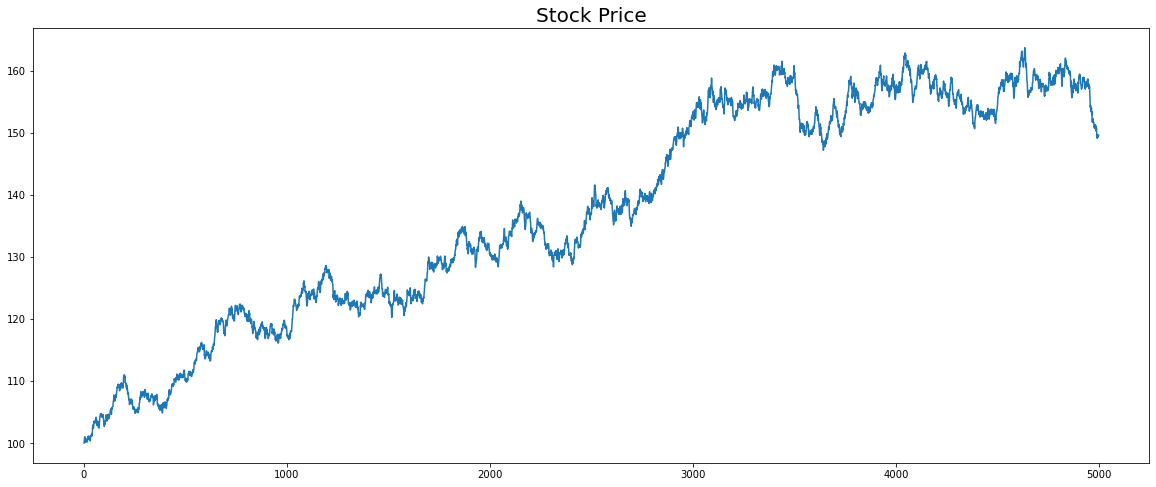

In [5]:
plt.figure(figsize=(20,8))
plt.plot(stockExchange._stockPriceProcess._priceProcess)
plt.title("Stock Price", size=20)
plt.show()

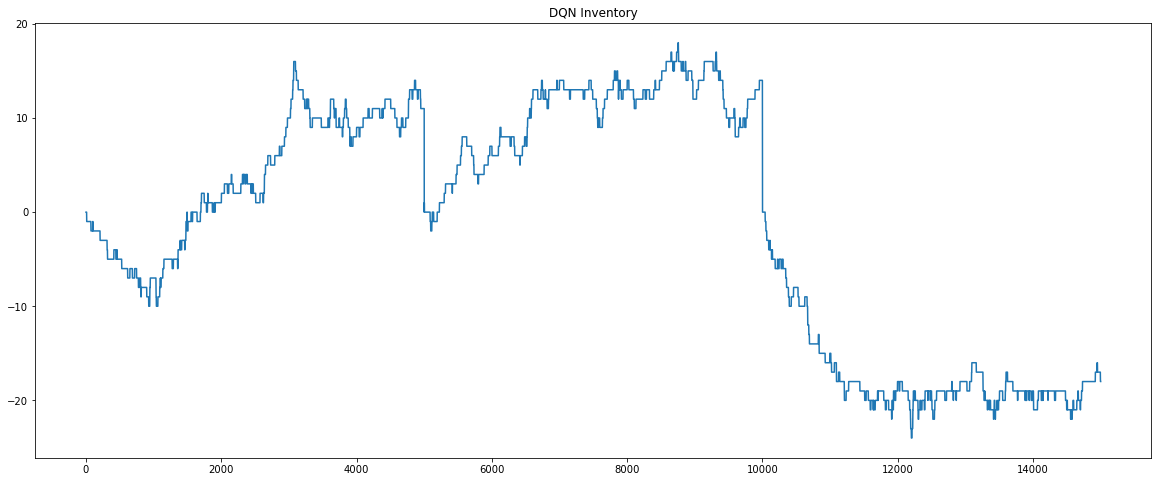

In [6]:
plt.figure(figsize=(20,8))
plt.plot(dqnInventory)
plt.title("DQN Inventory")
plt.show()

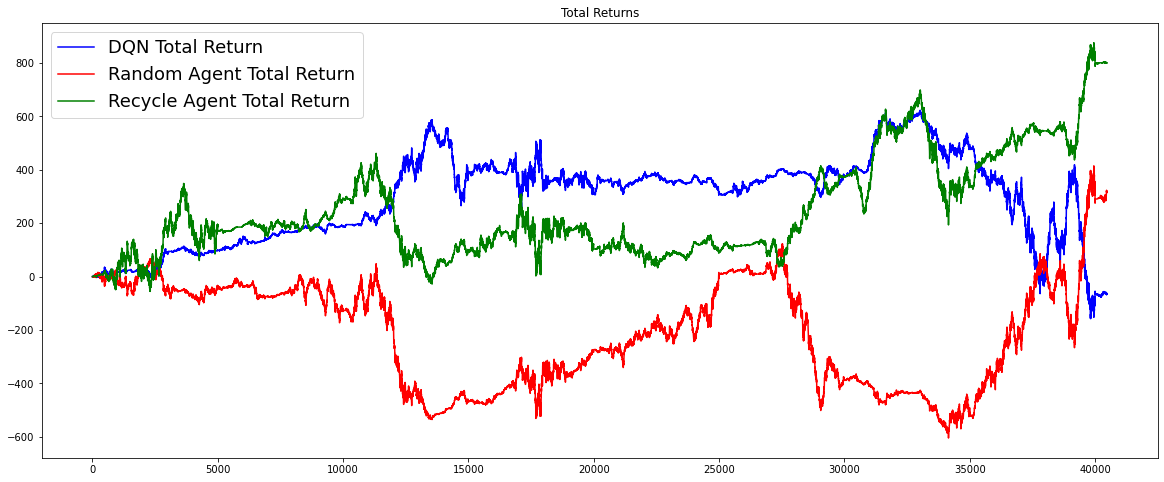

In [5]:
plt.figure(figsize=(20,8))
plt.plot(dqnTotalReturn, label='DQN Total Return', color='blue')
plt.plot(randomAgentTotalReturn, label='Random Agent Total Return', color='red')
plt.plot(recycleAgentTotalReturn, label='Recycle Agent Total Return', color='green')
plt.title("Total Returns")
plt.legend(fontsize=18)
plt.show()